# 4.2 손실함수
신경망은 '손실함수'(비용함수)를 기준으로 최적의 매개변수 값을 탐색한다.<br>
- 오차제곱합
- 엔트로피 오차

### 오차제곱합(SSE, Sum of Squares for Error)

In [1]:
# 한 개의 출력 세트, 10개의 인덱스로 구성된다.
y=[0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
t=[0, 0, 1, 0, 0, 0, 0, 0, 0, 0] # 원-핫-인코딩

import numpy as np
def sum_squares_error(y, t):
    return 0.5*np.sum((y-t)**2)

sum_squares_error(np.array(y), np.array(t))

0.09750000000000003

In [2]:
y=[0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
sum_squares_error(np.array(y), np.array(t)) # 손실함수가 매우 커짐

0.5975

### 교차 엔트로피 오차(CEE, Cross Etropy Error)
-정답 레이블 x 자연로그(출력 결과, 확률)의 합 -> 정답 레이블과 일치할 때 확률이 높을 수록, 손실함수가 낮다. 즉, 성능이 정확하다.

In [3]:
def cross_entropy_error(y,t):
    delta= 1e-7
    return -np.sum(t*np.log(y+delta)) # np.log는 자연로고임

y=[0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
t=[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

In [4]:
y=[0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0] # 정답일 때, 확률이 0.6에서 0.1로 감소 -> 손실함수 값이 증가
cross_entropy_error(np.array(y), np.array(t))

2.302584092994546

### 미니배치 학습
많은 훈련 데이터 중에서 무작위로 일부 데이터를 골라 학습하는 방법<br>
np.random.choice(전체 데이터 수, 원하는 데이터 수) -> 배열로 반환

In [5]:
from mnist import load_mnist

(x_train, t_train), (x_test, t_test)=load_mnist(normalize=True, one_hot_label=True)
print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [6]:
# np.random.choice()사용 -> 6만개의 train 데이터셋에서 10개의 랜덤한 데이터 선택
train_size = x_train.shape[0] # 60,000개
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch =t_train[batch_mask]

In [7]:
np.random.choice(60000, 10) #배열로 반환

array([ 2506, 48800, 26153, 35890, 16312,  3835,  4082,  9084, 44746,
       27681])

In [8]:
# 정답 레이블이 원-핫-레이블
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size) # CEE에서는 (배치 수, 클래스 수)로 받아야 하기 때문
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(t*np.log(y+1e-7))/batch_size

In [9]:
# 정답 레이블이 숫자 레이블
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] +1e-7))/batch_size # 배치가 여러 개라면, 숫자 레이블을 좌표로 여길 수 있다.

In [10]:
y=[0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
t=[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
cross_entropy_error(np.array(y), np.array(t))

23.718987110506905

### 손실함수를 설정하는 이유

하나의 매개변수를 변화시키면서 손실함수를 지켜보자. 작은 변화로 인해 손실함수가 변하는 것을 확인할 수 있다. <br>
하지만, 정확도를 지표로 삼는다면 매개변수를 작게 변화시켜도 결과가 달라지지 않을 수 있다.<br>
가령 100개의 사진 중에서 30개 사진이 정확하다고 할 때, 매개변수 하나를 변화시켜도 여전히 정확도는 30%일 수도 있다.<br><br>
지표를 정하는 것은 매개변수의 최적화이기 때문에, 지표의 핵심은 매개변수의 변화를 더 잘 반영할 수 있는 함수다.<br>
마찬가지로, 활성화 함수로 계단 함수 대신 시그모이드 함수를 사용한다.

# 4.3 수치 미분

함수 f의 x 위치에서 기울기를 구하는 코드를 구현할 때, 주의할 점 두 가지가 있다.<br>
- 반올림 오차: h에 1e-4를 넣는 것이 적당하다.
- 중앙 차분: h를 0에 수렴하는데 한계가 있어서 오차가 발생하기 마련, x+h 와 x-h사이의 기울기로 구한다.

In [11]:
def numerical_diff(f, x):
    h=1e-4
    return (f(x+h)-f(x-h))/(2*h)

예시

In [12]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

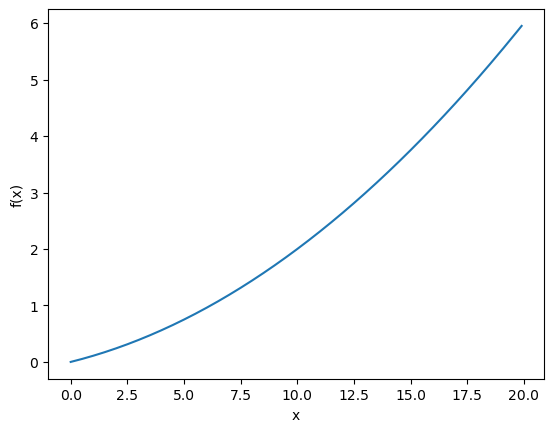

In [13]:
import matplotlib.pyplot as plt
x=np.arange(0.0, 20.0, 0.1)
y=function_1(x)

plt.xlabel('x')
plt.ylabel('f(x)')
plt.plot(x,y)
plt.show()

In [14]:
numerical_diff(function_1, 5)

0.1999999999990898

편미분

In [15]:
def function_2(x):
    return x[0]**2 + x[1]**2

In [16]:
# x_0=3, x_1=4
def function_tmp1(x0):
    return x0*x0 + 4.0*2.0
def function_tmp2(x1):
    return x1*x1 + 3.0*2.0

In [17]:
numerical_diff(function_tmp1, 3.0)

6.00000000000378

In [18]:
numerical_diff(function_tmp2, 4.0)

7.999999999999119

# 4.4 기울기

In [19]:
# 기울기 동시에 구하기
def numerical_gradient(f,x):
    h=1e-4
    grad=np.zeros_like(x) # x배열이랑 같은 사이즈로 만들기

    for idx in range(x.size): # 각 좌표마다 기울기 계산
        tmp_val = x[idx]
        # f(x+h) 계산
        x[idx]=tmp_val+h
        fxh1=f(x)

        # f(x-h) 계산
        x[idx]=tmp_val-h
        fxh2 = f(x)

        grad[idx] = (fxh1-fxh2)/(2*h)
        x[idx]=tmp_val # 값 복원

    return grad

In [20]:
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([6., 8.])

### 경사법(경사하강법)

In [21]:
# f는 최적화하려는 함수
# init_x는 초기 x값
# lr은 학습률
# step_num은 경사법 반복 횟수

def gradient_descent(f, init_x, lr, step_num):
    x = init_x

    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= -lr * grad
    return x

In [22]:
init_x=np.array([-3.0, 4.0])
gradient_descent(function_2, init_x, lr=0.1, step_num=100)

array([-2.48421019e+08,  3.31261790e+08])

In [23]:
# 학습률이 너무 클 때
init_x=np.array([-3.0, 4.0])
gradient_descent(function_2, init_x, lr=10.0, step_num=100)

array([-2.63011810e+12,  3.08739746e+12])

In [24]:
# 학습률이 너무 작을 때
init_x=np.array([-3.0, 4.0])
gradient_descent(function_2, init_x, lr=1e-10, step_num=100)

array([-3.00000006,  4.00000008])

학습률이 너무 크면 발산하고, 너무 작으면 끝까지 갱신되지 않는다.

In [25]:
from functions import softmax, cross_entropy_error
from gradient import numerical_gradient

class simpleNet:
    # 정규분포로 초기화
    def __init__(self):
        self.W = np.random.randn(2,3)
    def predict(self, x):
        return np.dot(x, self.W)
    def loss(self, x, t):
        z=self.predict(x)
        y=softmax(z)
        loss=cross_entropy_error(y, t)
        
        return loss

In [26]:
net = simpleNet()
print(net.W) # 가중치 매개변수, 임의로 만든 dummy다.

[[ 0.65222647  1.77414962 -1.91357221]
 [ 1.18231963  0.63247603  1.12466604]]


In [27]:
x=np.array([0.6, 0.9])
p=net.predict(x)
print(p)

[ 1.45542355  1.6337182  -0.13594389]


In [28]:
np.argmax(p) # 최댓값의 인덱스

1

In [29]:
t=np.array([0,0,1]) # 정답 레이블
net.loss(x, t)

2.466345038726386

In [30]:
def f(w):
    return net.loss(x, t)

dW=numerical_gradient(f, net.W)

# 한 층의 매개변수에 대해 편미분한 기울기
print(dW)

[[ 0.25012223  0.29894044 -0.54906267]
 [ 0.37518334  0.44841066 -0.823594  ]]


w_11을 h만큼 늘리면 손실함수가 0.1만큼 증가한다고 볼 수 있다. 따라서 w_11은 음의 방향으로, w_23은 양의 방향으로 갱신해야 손실함수가 줄어든다.<br>
또한 w_11보다 w_23이 한 번 갱신할 때, 크게 갱신하는 것을 알 수 있다.

In [31]:
f = lambda w : net.loss(x, t) # python에서는 lambda기법 사용하기
dW=numerical_gradient(f, net.W)
print(dW)

[[ 0.25012223  0.29894044 -0.54906267]
 [ 0.37518334  0.44841066 -0.823594  ]]


# 4.5 학습 알고리즘 구현하기

### 확률적 경사 하강법(SGD, Stochastic Gradient Descent)
미니배치 단계에서 배치를 무작위로 선정하는 방법

In [32]:
from mnist import load_mnist
from functions import *
from gradient import numerical_gradient

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params={}
        self.params['W1'] = weight_init_std*np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std*np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        return y

    # x: 입력 데이터, t: 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)

        return cross_entropy_error(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argamx(t, axis=1)

        accuracy = np.sum(y==t)/float(x.shape[0])
        return accuracy

    # x: 입력 데이터, t: 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

In [33]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
net.params['W1'].shape

(784, 100)

In [35]:
x = np.random.rand(100, 784)
y = net.predict(x)

In [ ]:
x = np.random.rand(100, 784)
t = np.random.rand(100, 10)

grads = net.numerical_gradient(x, t) # 기울기 계산

grads['W1'].shape

### 미니배치 학습 구현하기

In [ ]:
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
train_loss_list=[]

# 하이퍼파라미터
iters_num = 1000 # 반복 횟수
train_size = x_train.shape[0] # 60,000
batch_size = 50 # 배치 크기
learning_rate=0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size) # np.random.choice()는 batch_size만큼 무작위 인덱스를 반환한다.
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate*grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(iters_num, train_loss_list)

### 시험 데이터로 평가
1 에포크별로 훈련 데이터와 시험 데이터에 대한 정확도를 기록한다. 에포크는 학습에서 훈련 데이터를 모두 소진했을 때의 횟수

In [ ]:
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 1000 # 반복 횟수
train_size = x_train.shape[0] # 60,000
batch_size = 50 # 배치 크기
learning_rate=0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에포크당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size) # np.random.choice()는 batch_size만큼 무작위 인덱스를 반환한다.
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate*grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1에포크당 정확도 계산
    if i%iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc:"+str(train_acc)+", "+str(test_acc))